# LOGISTIC REGRESSION MODEL
CONTRIBUTORS: Will Sessoms, John Cordwell, Ben Belandres, Daniel Moon, and James Ogle

PURPOSE: The jupyter notebook is designed to take in Ednet-KT1 data set and merge all of the files into one csv. The data is used to build a logistic regression model that predicts if the question was answered correctly based off the average question accuracy, question_id, bundle_id, and elapsed time to asnwer question. The model will be used as a baseline to determine if a relationship can be found between the data taken from students and if the student answered correctly.

### Dataset Content Description
- **timestamp** is the moment the question was given, represented as Unix timestamp in milliseconds.
- **solving_id** represents each learning session of students corresponds to each bunle. It is a form of single
integer, starting from 1 .
- **question_id** is the ID of the question that given to student, which is a form of q{integer}.
- **user_answer** is the answer that the student submitted, recorded as a character between a and d inclusively.
- **elapsed_time** is the time that the students spends on each question in milliseconds.


### Our Dataset
We plan to reduce the data to have only columns for student_id, question_id, bundle_id, tags, elapsed_time, and correct
- **student_id** is the ID of the student. We will not use this for training, but it's necessary for sorting so that we don't leak data
- **bundle_id** is the bundle that a question is in. Bundles are sets of questions that reference the same passage/image/video/etc
- **tags** are the skills associated with a certain question. Most question have multiple tags.
- **Correct** is whether or not the student got the answer correct in that interaction

In [39]:
import os
import polars as pl # Using polars instead of pandas for speed. >9 million lines in 784k csv files.
from tqdm import tqdm
import pandas as pd
import pyarrow as pa # Needed for conversion from polars to pandas
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

### Model 1 Baseline Accuracy
By taking the student accuracy, we are able to have a baseline off how accurately the student's guess the correct asnwer. Our model should aim to be above this score to be consisdered useful

Designed by John Cordwell

In [40]:
# kaggle_dir = '/kaggle/input/student-testing'
# combine_dataset = 'combined_dataset.csv'
# file = os.path.join(kaggle_dir, 'combined_dataset.csv')
file = './Data/combined_dataset.csv'
df = pl.read_csv(file).to_pandas() # Convert from polars to pandas

correct_count = df['correct'].value_counts()
student_acc = correct_count.get(1) / (correct_count.get(0) + correct_count.get(1))
print(f"Overall student accuracy: {student_acc:.4%}")
del df

Overall student accuracy: 65.3418%


Our baseline accuracy to compare against is 65.3418%, which is what we would get if the model guessed that the student will be 'correct' every time.

## Preprocessing:
- Remove student_id
- add in question_acc feature
- Remove tags
- Standardize elapsed_time

Designed by Daniel Moon

#### Read in Data
#### Author for Function: James Ogle
The function below will only read in a set number of students from data. The purpose is to speed up training and testing without sacrificing accuracy by not reading in as much.

In [41]:
# designed for parqeuts only, can be easily adjusted to work with csv's if needed
def read_in_data(file, num_students):
    # getting the unique student_ids from file
    # total number of students grabbed will be based off num_students
    student_ids = pl.scan_parquet(file).select("student_id").collect()
    all_unique_ids = student_ids["student_id"].unique(maintain_order=True)

    # Shuffling and grabbing number of students
    unique_ids = all_unique_ids.sample(fraction=1.0, shuffle=True, seed=865)[:num_students]
    
    # find last occurance of this student
    mask = student_ids["student_id"].is_in(unique_ids)
    last_row_idx = mask.arg_true().max() # get maximum idx where any selected student exists
    num_rows_read = last_row_idx + 1

    # read in number of rows
    df = pl.read_parquet(file, n_rows=num_rows_read)

    # Filter for handling interleaved student_ids
    # should not be an issue with our dataset but will be implemented as a precuation
    df_final = df.filter(pl.col("student_id").is_in(unique_ids))

    return df_final.to_pandas()

In [42]:
# We split our data into 2 separate sets in the prep_data file
train_file = "./Data/final_train_data.parquet"
val_file = "./Data/final_val_data.parquet"
# train_file = os.path.join(kaggle_dir, 'final_train_data.parquet')
# val_file = os.path.join(kaggle_dir, 'final_val_data.parquet')
train_df = read_in_data(train_file, num_students=2000)
val_df = read_in_data(val_file, num_students=500)

acc_per_question = train_df.groupby('question_id')['correct'].mean()
train_df['question_acc'] = train_df['question_id'].map(acc_per_question)
val_df['question_acc'] = val_df['question_id'].map(acc_per_question)

# Remove unnecessary columns and move 'correct' to the end
train_df = train_df.drop(columns=['student_id', 'tags', 'timestamp', 'question_id', 'bundle_id', 'num_interactions'])
val_df = val_df.drop(columns=['student_id', 'tags', 'timestamp', 'question_id', 'bundle_id', 'num_interactions'])
train_df.insert(len(train_df.columns)-1, 'correct', train_df.pop('correct'))
val_df.insert(len(val_df.columns)-1, 'correct', val_df.pop('correct'))

train_df

,elapsed_time,bayes_rolling_acc,watched_lecture,forgetful_ben_score,student_streak,question_acc,correct
0,16000,0.653523,0,0,0,0.857143,1.0
1,26000,0.670022,0,1,1,0.704918,1.0
2,32000,0.685021,0,2,2,0.467153,1.0
3,47000,0.698716,0,3,3,0.322917,0.0
4,42000,0.669602,0,2,-1,0.293578,1.0
...,...,...,...,...,...,...,...
258841,1000,0.618095,0,-1,1,0.664634,0.0
258842,1000,0.595202,0,-3,-1,0.550562,1.0
258843,1000,0.609659,0,-1,1,0.444444,0.0
258844,1000,0.588637,0,-1,-1,0.321429,0.0


Finish preparation of data set by filling in NA values with 0. We are assuming if the student did not answer in time, then the answer would be counted wrong.

In [43]:
y_train = train_df['correct'].fillna(0)
print(y_train)
X_train = train_df.drop(columns=['correct'])

y_val = val_df['correct'].fillna(0)
X_val = val_df.drop(columns=['correct'])

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

0         1.0
1         1.0
2         1.0
3         0.0
4         1.0
         ... 
258841    0.0
258842    1.0
258843    0.0
258844    0.0
258845    0.0
Name: correct, Length: 258846, dtype: float64


#### Plotting function
Designed by James Ogle
- used to display the distribution of the data set

In [44]:
def get_info (column):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 5))
  ax1.boxplot(column.dropna())
  ax1.set_title(f"Distribution of {column.name}")
  ax1.set_ylabel("Value")

  ax2.hist(column.dropna(), bins=20)
  ax2.set_title(f"Histogram of {column.name}")
  ax2.set_ylabel("Frequency")
  ax2.set_xlabel("Value")

  ax3.scatter(np.arange(len(column.dropna())), column.dropna())
  ax3.set_title(f"{column.name} Values")
  ax3.set_ylabel("Value")
  ax3.set_xlabel("")

  plt.tight_layout(pad=3.0)
  plt.show()
  return column.std()

#### Data Knowledge
Designed by James Ogle

Based on the data sampling (50,000 samples), we are able to see the skewness and the standard deviations of each data set. Only taking a sample due to how large the dataset is and the slowness it causes in runnign the program. While taking a sample can cause issues with not all of the data being represented, I believe this trade-off is worth since we are just using it to get an idea of what the data looks like.

 - The question accuracy data based off random sampling of 50,000 shows that most questions had
      around 55% to 85% accuracy.
 -  Due to the skewness of elapsed time and question_acc, normalization will be applied to both the datasets

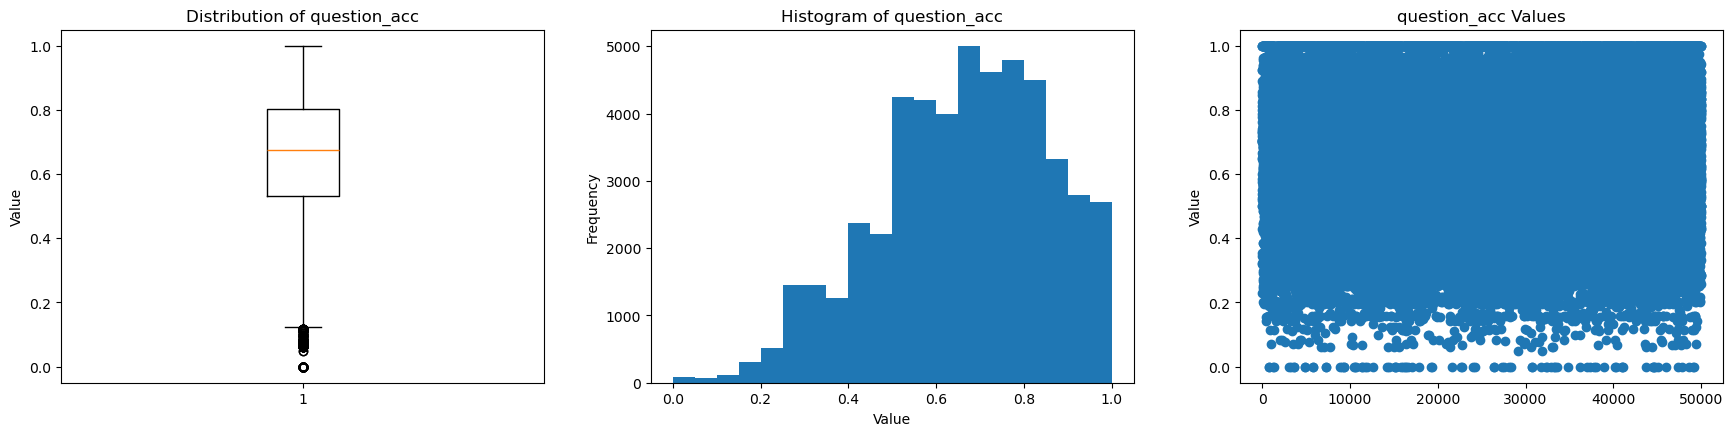

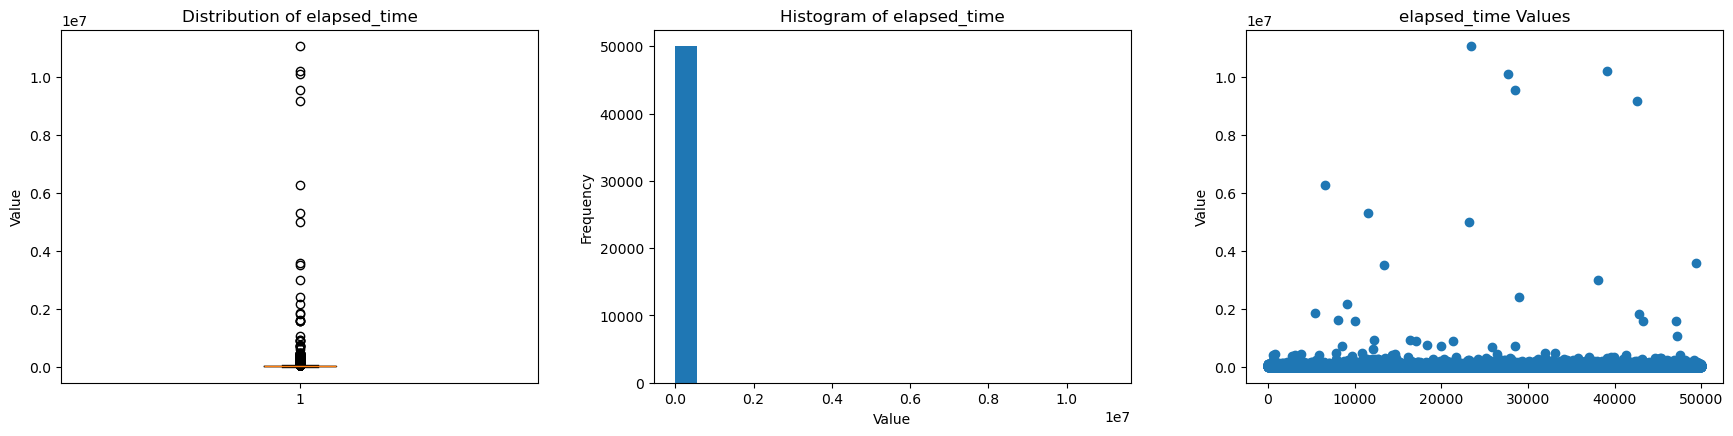

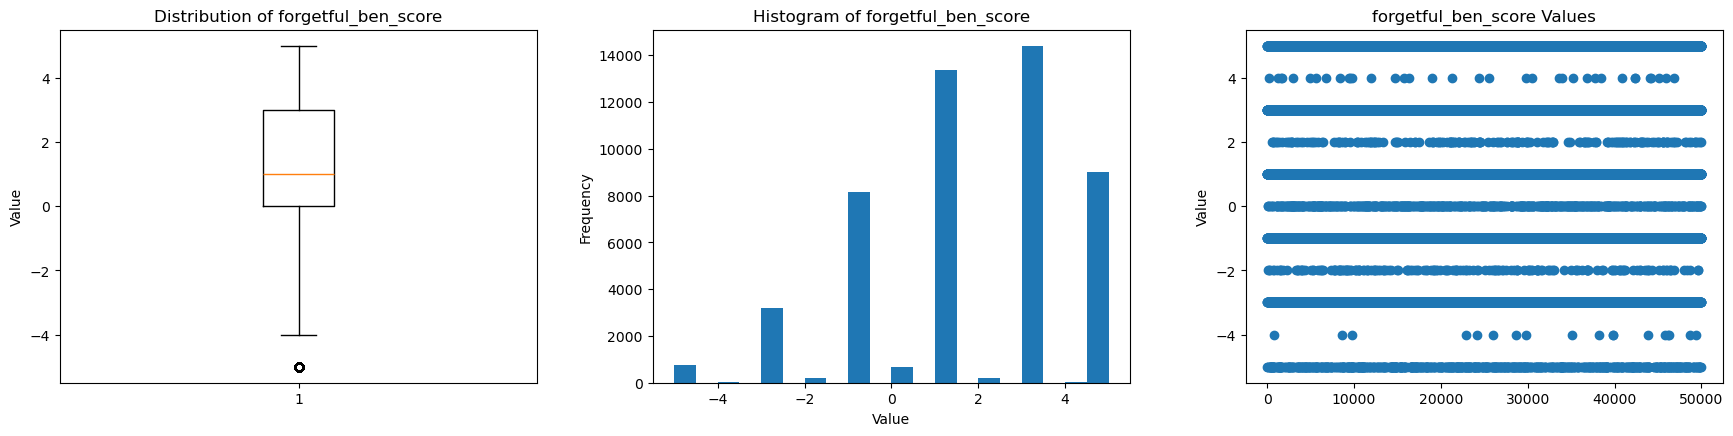

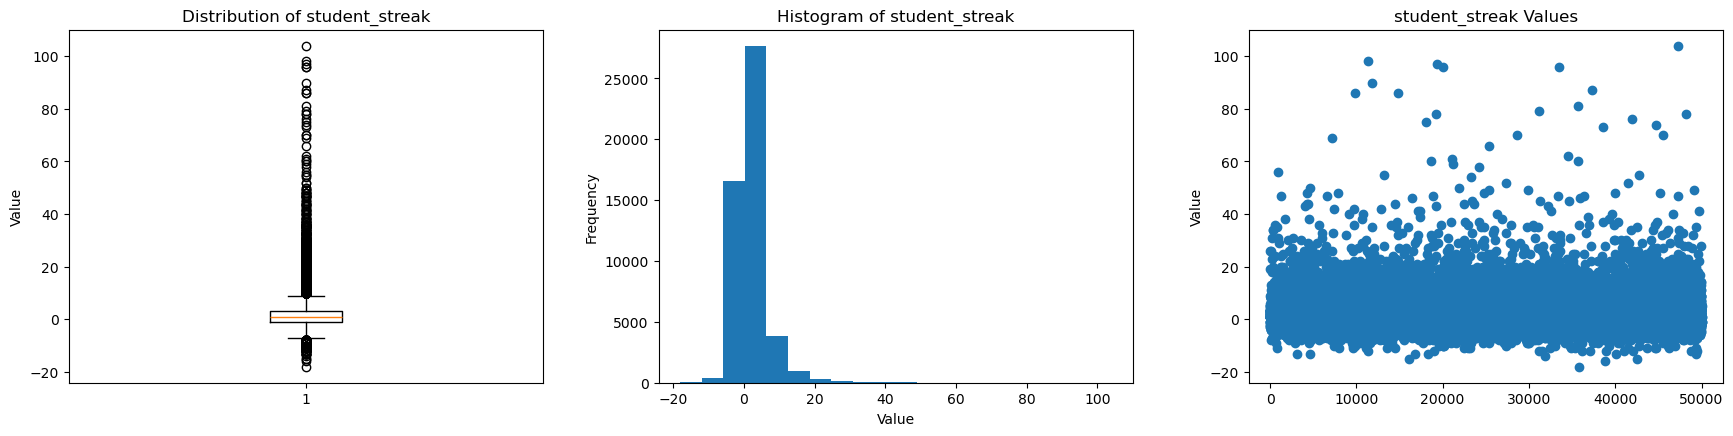

Standard Deviation of Question Accuracy: 0.1960
Standard Deviation of Elapsed Time: 116856.9672
Standard Deviation of Forgetful Ben Score: 2.4397
Standard Deviation of Student Streak: 4.8877



In [45]:
n_samples = min(50000, len(X_train))

quest_acc_sample = X_train['question_acc'].sample(n=n_samples)
elp_time_sample = X_train['elapsed_time'].sample(n=n_samples)
ben_score_sample = X_train['forgetful_ben_score'].sample(n=n_samples)
student_streak_sample = X_train['student_streak'].sample(n=n_samples)

std_dev_quest_acc = get_info(quest_acc_sample)
std_dev_elp_time = get_info(elp_time_sample)
std_dev_bs = get_info(ben_score_sample)
std_dev_ss = get_info(student_streak_sample)

print(f"Standard Deviation of Question Accuracy: {std_dev_quest_acc:.4f}\n"
      f"Standard Deviation of Elapsed Time: {std_dev_elp_time:.4f}\n"
      f"Standard Deviation of Forgetful Ben Score: {std_dev_bs:.4f}\n"
      f"Standard Deviation of Student Streak: {std_dev_ss:.4f}\n")

# clear up for memeory since it won't be needed anymore
del quest_acc_sample
del elp_time_sample
del ben_score_sample
del student_streak_sample

Data is normalized based off results of distribution displayed above
- question_id, elapsed_time, and bundle_id will all be normalized based off standard scalar due to their skewed distributions based of histogram chart
- elapsed_time will most likely require some more data trimming due to the large outliers displayed above
- possiblility that we might be able to remove question_id or bundle_id without effecting accuracy too much as well

#### Training Logistic Model
Designed by Ben Belandres

Adjusted by James Ogle to only be trained off the total number of students in the dataset rather than by a set number in the X_train and X_val datasets
- wil be used to compare to the ensemble results found below

In [51]:
full_train = pl.read_parquet(train_file).to_pandas()
full_val = pl.read_parquet(val_file).to_pandas()

acc_per_question = full_train.groupby('question_id')['correct'].mean()
full_train['question_acc'] = full_train['question_id'].map(acc_per_question)
full_val['question_acc'] = full_val['question_id'].map(acc_per_question)

# Remove unnecessary columns and move 'correct' to the end
full_train = full_train.drop(columns=['student_id', 'tags', 'timestamp', 'question_id', 'bundle_id', 'num_interactions'])
full_val = full_val.drop(columns=['student_id', 'tags', 'timestamp', 'question_id', 'bundle_id', 'num_interactions'])
#full_train.insert(len(train_df.columns)-1, 'correct', train_df.pop('correct'))
#full_val.insert(len(val_df.columns)-1, 'correct', val_df.pop('correct'))


full_y_train = full_train['correct'].fillna(0)
full_X_train = full_train.drop(columns=['correct'])
full_X_train = full_X_train.fillna(0)

full_y_val = full_val['correct'].fillna(0)
full_X_val = full_train.drop(columns=['correct'])
full_X_val = full_X_val.fillna(0)

norm_scaler = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), ['elapsed_time', 'student_streak']),
        ('minmax', MinMaxScaler(), ['bayes_rolling_acc', 'question_acc', 'forgetful_ben_score'])
    ], remainder='passthrough'
)

pipe = make_pipeline(norm_scaler, LogisticRegression(max_iter=1000, random_state=865))
pipe.fit(full_X_train, full_y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standard', ...), ('minmax', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Logistic Model Results
Designed by Ben Belandres

In [52]:
# Predict on training set
y_hat = pipe.predict(full_X_train)
print(f"Model training accuracy is {accuracy_score(full_y_train, y_hat)*100:0.2f}%")
# Predict on validation set
y_hat = pipe.predict(full_X_val)
print(f"Model validation accuracy is {accuracy_score(full_y_val, y_hat)*100:0.2f}%")
del full_train, full_val, full_X_train, full_y_train, full_X_val, full_y_val

Model training accuracy is 71.43%


ValueError: Found input variables with inconsistent numbers of samples: [19215068, 76078858]

# Ensemble Method
#### Author: James Ogle
#### Models:
- Logistic Regression
- XGBoost Classifier
- Random Forest Classifier
- SGD Classifier (provides iterative tracking while log reg does not)
    - also known to work better with larger datasets
#### Sources:
- https://xgboosting.com/voting-ensemble-with-an-xgboost-model/
- https://medium.com/@silvaan/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
- https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- https://www.geeksforgeeks.org/machine-learning/ensemble-methods-in-python/
- https://mohitagr18.github.io/posts/links/Logistic_Regression.html (Logistic Regression w/ Mini-Batching Gradient Descent)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# function to show Cost History
def loss_curve(title, train_hist, val_hist, epochs):
    plt.figure(figsize=(10,5))
    plt.plot(epochs, train_hist, linewidth=1.5, label='Training Cost')
    plt.plot(epochs, val_hist, linewidth=1.5, label='Validation Cost')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()
    plt.title(title)
    plt.show

# function for getting the accuracy score of given model
# - clf_report = True -> print classification report and confusion matrix
# - returns validition, training score, and ConfusionMatrixDisplay
def model_acc(model, X_train, X_val, y_train, y_val, clf_report):
    model.fit(X_train, y_train)

    # training
    y_hat = model.predict(X_train)
    train_acc_score = accuracy_score(y_train, y_hat)
    print(f"Training accuracy is {train_acc_score*100:0.2f}%")

    # validation
    y_hat = model.predict(X_val)
    val_acc_score = accuracy_score(y_val, y_hat)
    print(f"Validation accuracy is {val_acc_score*100:0.2f}%")

    if clf_report == True:
        print(classification_report(y_val, y_hat))
        cm = confusion_matrix(y_val, y_hat)
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    return train_acc_score, val_acc_score, cmd

# function expects the ConfusionMatrixDisplay to already be processed
def plot_confusion_matrix (Title, cfDisplay):
    cfDisplay.plot()
    plt.title(Title)
    plt.show()

## Hyparameter Tuning
#### Purpose:
The testing will provide use with the best set of hyperparameters for each model. By doing this, we know that we are most likely determining the best result of each model when performing the ensemble. This gives us confidence that we will be choosing the best model with its the optimized hyperparameters for the model.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#------------------ SGD Classifier ------------------#
print("\n" + "="*70)
print("GRID SEARCH - SGD Classifier")
print("="*70)

sgd_params = {
    'sgdclassifier__loss': ['log_loss'],
    'sgdclassifier__penalty': ['l1', 'l2'],
    'sgdclassifier__alpha': [0.01, 0.05, 0.1],
    'sgdclassifier__max_iter': [250, 500, 1000],
    'sgdclassifier__early_stopping': [True, False]
}

sgd_model = SGDClassifier(random_state=865)
sgd_pipe = make_pipeline(norm_scaler, sgd_model)

# Since SGD Classifier isn't as computationally heavy as RF or XGBoost, I will use
# Grid Search here
grid_sgd = GridSearchCV(
    estimator=sgd_pipe,
    param_grid=sgd_params,
    cv=5,
    scoring='accuracy',
    verbose=0,
    return_train_score=False)

grid_sgd.fit(X_train, y_train)
# displaying scoring results
print(f"\nBest CV train score: {grid_sgd.best_score_:.4f}")
# displaying best parameters
print("\nBest Hyperparameters:")
for param, val in grid_sgd.best_params_.items():
    print(f"    {param}: {val}")

#------------------ Logistic Regression ------------------#
print("\n" + "="*70)
print("GRID SEARCH - Logistic Regression")
print("="*70)

lr_params = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}

lr_model = LogisticRegression(max_iter=1000, random_state=865)
lr_pipe = make_pipeline(norm_scaler, lr_model)

# Peforming Grid Search
grid_log = GridSearchCV(
    estimator=lr_pipe,
    param_grid=lr_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=False
    )

grid_log.fit(X_train, y_train)
# displaying best results
print(f"\nBest CV train score: {grid_log.best_score_:.4f}")
# displaying best parameters
print("\nBest Hyperparameters:")
for param, val in grid_log.best_params_.items():
    print(f"    {param}: {val}")

#------------------ XGBoost Classifier ------------------#
print("\n" + "="*70)
print("RANDOM SEARCH - XGBoost Classifier")
print("="*70)

xgb_params = {
    'xgbclassifier__n_estimators': [50, 100, 150],  # number of trees in ensemble
    'xgbclassifier__max_depth': [3, 4, 6, 8],       # max depth of each tree
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
    'xgbclassifier__reg_lambda': [0.0001, 0.001, 0.01, 0.1],
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              random_state=865,
                              n_jobs=-1, # parallelizes tree builiding
                              tree_method='hist', # traditionally faster algorithm -> implements through histograms
                              subsample=0.7 # only using 70% training data
                              ) 

xgb_pipe = make_pipeline(norm_scaler, xgb_model)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_params,
    n_iter=70,
    cv=5,
    n_jobs=1, # only performing one at a time to prevent copying in cv
    scoring='accuracy',
    verbose=True,
    return_train_score=False
    )

xgb_search.fit(X_train, y_train)
# displaying best results
print(f"\nBest CV train score: {xgb_search.best_score_:.4f}")
# displaying best parameters
print("\nBest Hyperparameters:")
for param, val in xgb_search.best_params_.items():
    print(f"    {param}: {val}")

#------------------ Random Forest Classifier ------------------#
print("\n" + "="*70)
print("RANDOM SEARCH - Random Forest Classifier")
print("="*70)

rf_params = {
    'randomforestclassifier__n_estimators': [50, 100], # small n_estimator range due to extremely large dataset
    'randomforestclassifier__max_depth': [50, 100],
    'randomforestclassifier__min_samples_split': [10, 20, 30],
    'randomforestclassifier__min_samples_leaf': [2, 4, 8, 10],
    'randomforestclassifier__bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=865)
rf_pipe = make_pipeline(norm_scaler, rf_model)

rand_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_params,
    n_iter=30, # number of samples to have out of all the combinations
    cv=5,
    n_jobs=-1, # using all cpu cores for parallel processing
    verbose=2, # displays progress during search
    scoring='accuracy',
    return_train_score=False
    )

rand_rf.fit(X_train, y_train)
# displaying best results
print(f"\nBest CV train score: {rand_rf.best_score_:.4f}")
# displaying best parameters
print("\nBest Hyperparameters:")
for param, val in rand_rf.best_params_.items():
    print(f"    {param}: {val}")


#---------- Saving Models -------------#
best_sgd_model = grid_sgd.best_estimator_
best_log_model = grid_log.best_estimator_
best_xgb_model = xgb_search.best_estimator_
best_rf_model = rand_rf.best_estimator_


GRID SEARCH - SGD Classifier

Best CV train score: 0.7151

Best Hyperparameters:
    sgdclassifier__alpha: 0.01
    sgdclassifier__early_stopping: True
    sgdclassifier__loss: log_loss
    sgdclassifier__max_iter: 250
    sgdclassifier__penalty: l1

GRID SEARCH - Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best CV train score: 0.7259

Best Hyperparameters:
    logisticregression__C: 0.1
    logisticregression__penalty: l1
    logisticregression__solver: liblinear

RANDOM SEARCH - XGBoost Classifier
Fitting 5 folds for each of 70 candidates, totalling 350 fits

Best CV train score: 0.7300

Best Hyperparameters:
    xgbclassifier__reg_lambda: 0.0001
    xgbclassifier__n_estimators: 100
    xgbclassifier__max_depth: 6
    xgbclassifier__learning_rate: 0.05

RANDOM SEARCH - Random Forest Classifier
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best CV train score: 0.7261

Best Hyperparameters:
    randomforestclassifier__n_estimators

#### Cost History of XGBoost Classifier

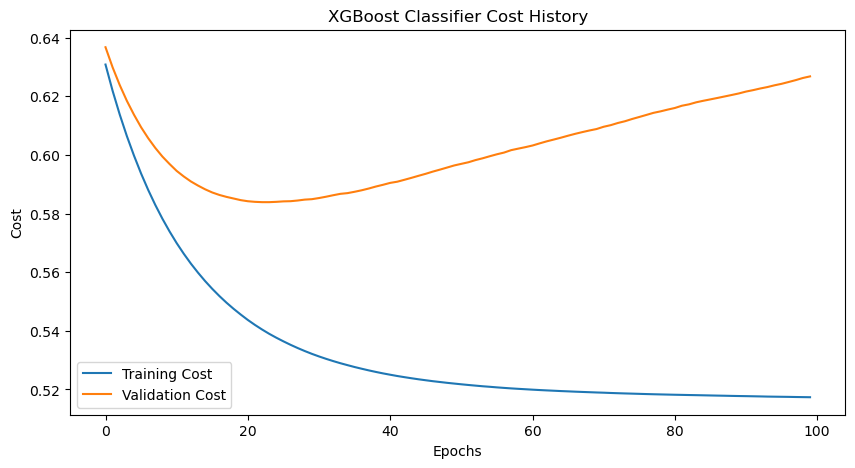

In [ ]:
## Testing Code for Cost History Graphs
X_train_trans = best_xgb_model.named_steps['columntransformer'].transform(X_train)
X_val_trans = best_xgb_model.named_steps['columntransformer'].transform(X_val)
eval_set = [(X_train_trans, y_train), (X_val_trans, y_val)]

best_xgb_model.fit(
    X_train, y_train,
    xgbclassifier__eval_set=eval_set,
    xgbclassifier__verbose=False)

results = best_xgb_model.named_steps['xgbclassifier'].evals_result()
xgb_train_loss = results['validation_0']['logloss']
xgb_val_loss = results['validation_1']['logloss']
boosting_rounds = range(len(xgb_train_loss))
loss_curve('XGBoost Classifier Cost History', xgb_train_loss, xgb_val_loss, boosting_rounds)

## Ensemble Testing w/ Best Parameters


Voting Classifier Performance:
Training accuracy is 74.40%
Validation accuracy is 69.82%
              precision    recall  f1-score   support

         0.0       0.59      0.41      0.49     26644
         1.0       0.73      0.85      0.79     50474

    accuracy                           0.70     77118
   macro avg       0.66      0.63      0.64     77118
weighted avg       0.68      0.70      0.68     77118



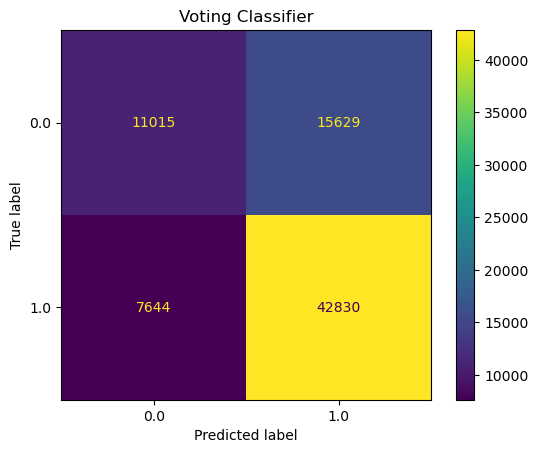


SGD Classifier Model:
Training accuracy is 71.52%
Validation accuracy is 68.58%
              precision    recall  f1-score   support

         0.0       0.59      0.28      0.38     26644
         1.0       0.70      0.90      0.79     50474

    accuracy                           0.69     77118
   macro avg       0.65      0.59      0.59     77118
weighted avg       0.67      0.69      0.65     77118



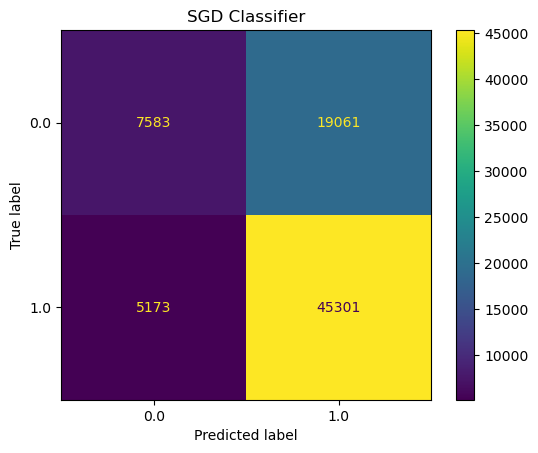


Logistic Regression Model:
Training accuracy is 72.59%
Validation accuracy is 69.45%
              precision    recall  f1-score   support

         0.0       0.58      0.41      0.48     26644
         1.0       0.73      0.84      0.78     50474

    accuracy                           0.69     77118
   macro avg       0.66      0.63      0.63     77118
weighted avg       0.68      0.69      0.68     77118



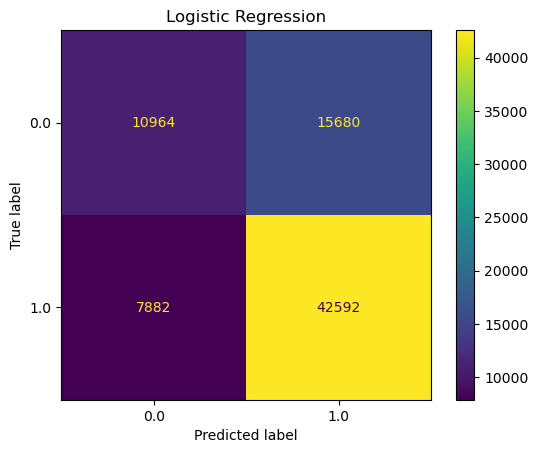


Random Forest Classifier Model:
Training accuracy is 78.44%
Validation accuracy is 69.44%
              precision    recall  f1-score   support

         0.0       0.57      0.45      0.50     26644
         1.0       0.74      0.82      0.78     50474

    accuracy                           0.69     77118
   macro avg       0.66      0.64      0.64     77118
weighted avg       0.68      0.69      0.68     77118



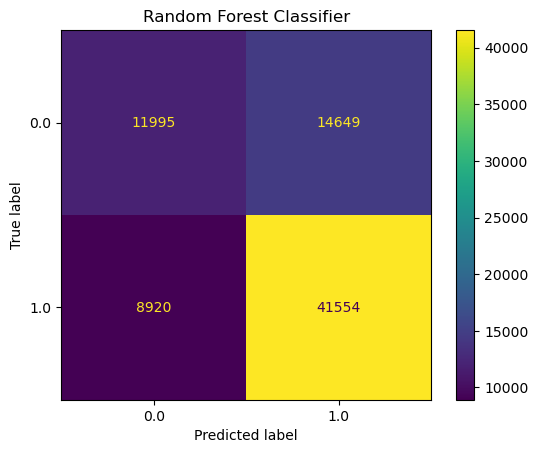


XGBoost Classifier Model:
Training accuracy is 73.34%
Validation accuracy is 69.76%
              precision    recall  f1-score   support

         0.0       0.58      0.45      0.51     26644
         1.0       0.74      0.83      0.78     50474

    accuracy                           0.70     77118
   macro avg       0.66      0.64      0.64     77118
weighted avg       0.69      0.70      0.69     77118



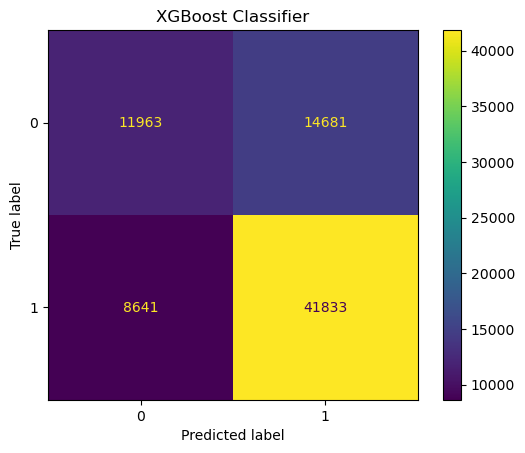


 Comparison with Invidividual Models using Validation:
Logistic Regression:      0.6945
Random Forest Classifier: 0.6944
XGBoost:                  0.6976
Voting Classifier:          0.6982


In [ ]:
from sklearn.ensemble import VotingClassifier # chosen due to the target being 0 or 1 (classification)

# Performing with Soft Voting
# - based off probabilities rather than class labels
voting_clf = VotingClassifier(
    estimators = [
        ('lr', best_log_model),
        ('rf', best_rf_model),
        ('xgb', best_xgb_model),
        ('sgd', best_sgd_model)
    ],
    voting='soft', # uses probability
    weights=[1, 1, 1.3, 0.8 ]
)

voting_clf.fit(X_train, y_train)

# Calling model_acc and plot_confusion_matrix functions for all models to display the results
print("\nVoting Classifier Performance:")
voting_train_acc, voting_val_acc, voting_cmd = model_acc(voting_clf, X_train, X_val, y_train, y_val, True)
plot_confusion_matrix('Voting Classifier', voting_cmd)
print("\nSGD Classifier Model:")
sgd_train_acc, sgd_val_acc, sgd_cmd = model_acc(best_sgd_model, X_train, X_val, y_train, y_val, True)
plot_confusion_matrix('SGD Classifier', sgd_cmd)
print("\nLogistic Regression Model:")
log_train_acc, log_val_acc, log_cmd = model_acc(best_log_model, X_train, X_val, y_train, y_val, True)
plot_confusion_matrix('Logistic Regression', log_cmd)
print("\nRandom Forest Classifier Model:")
rf_train_acc, rf_val_acc, rf_cmd = model_acc(best_rf_model, X_train, X_val, y_train, y_val, True)
plot_confusion_matrix('Random Forest Classifier', rf_cmd)
print("\nXGBoost Classifier Model:")
xgb_train_acc, xgb_val_acc , xgb_cmd = model_acc(best_xgb_model, X_train, X_val, y_train, y_val, True)
plot_confusion_matrix('XGBoost Classifier', xgb_cmd)

print(f"\n Comparison with Invidividual Models using Validation:")
print(f"Logistic Regression:      {log_val_acc:.4f}")
print(f"Random Forest Classifier: {rf_val_acc:.4f}")
print(f"XGBoost:                  {xgb_val_acc:.4f}")
print(f"Voting Classifier:          {voting_val_acc:.4f}")

### ROC Curve
Author: James Ogle

will be used to better the compare the true/false positive rates of each model

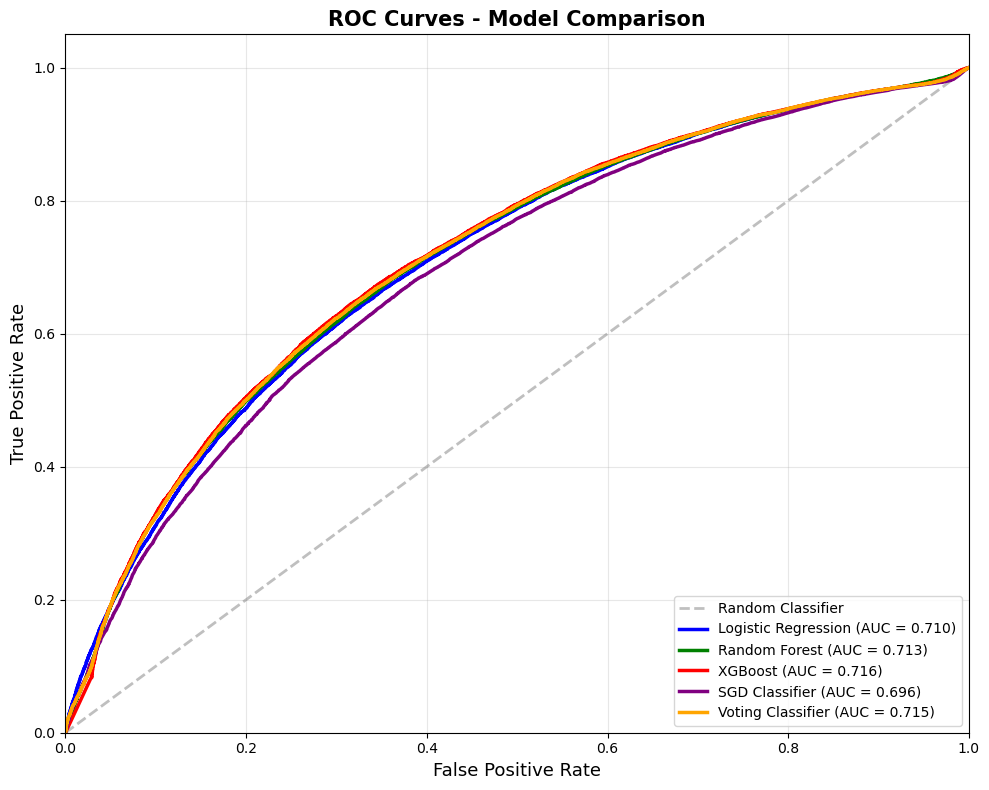

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Creating ROC curve graph w/ all models
models = {
    'Logistic Regression': best_log_model,
    'Random Forest': best_rf_model,
    'XGBoost': best_xgb_model,
    'SGD Classifier': best_sgd_model,
    'Voting Classifier': voting_clf
}

plt.figure(figsize=(10, 8))
# base line for a Random Classifier
plt.plot([0,1],[0,1], color='gray', lw=2, linestyle='--', 
         label='Random Classifier', alpha=0.5)

colors = ['blue', 'green', 'red', 'purple', 'orange']

for ((name, model), color) in zip(models.items(), colors):
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val)[:,1]
    else:
        y_pred_proba = model.decision(X_val)
    
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_acc = roc_auc_score(y_val, y_pred_proba)
    plt.plot(fpr, tpr, lw=2.5, color=color, 
             label=f'{name} (AUC = {roc_acc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves - Model Comparison', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## MLP Classifier
#### Purpose:
Using the sklearn neural network library, I am going to implement a MLP classifier. While previous models such as Random Forest Classifier and Logistic Regression have been able to score ~73% for validation, there are drawbacks to using them. The Random Forest requires the whole entire dataset to be read in at once which can require massive amounts of computation for large datasets. The logistic regression is more computationally efficient but can't learn non-linear datasets as well as random forest. I am hoping to be able to meeting somewhere in the middle with the MLP since it can learn larger non-linear datasets better than logistic regression while handling larger datasets better than random forest.